In [16]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import numpy as np
import theano
import theano.tensor as T
import lasagne
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from rnn_lib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%reload_ext autoreload

CROSS VALIDATION FOR HYPERPARAMETERS

In [2]:
N_HIDDEN = 100
NDIM = 2
TRAIN_SIZE = int(1e5)
TEST_SIZE = int(1e4)
SEQ_LENS = [10, 50, 70, 100, 150, 200, 300, 400]

LEARNING_RATE = 0.001
GRAD_CLIP = 10
BATCH_SIZE = 20
NUM_EPOCHS = 10

In [3]:
def gen_add_data(length, n_batch=BATCH_SIZE):
    X = np.concatenate([np.random.uniform(size=(n_batch, length, 1)),
                        np.zeros((n_batch, length, 1))],
                        axis=-1)
    y = np.zeros((n_batch,))
    
    X[np.arange(n_batch), np.random.randint(length/10, size=n_batch), 1] = 1
    X[np.arange(n_batch), np.random.randint(length/2, length, size=n_batch), 1] = 1
    # Multiply and sum the dimensions of X to get the target value
    y = np.sum(X[:, :, 0] * X[:, :, 1], axis=1)
    
    return (X.astype(theano.config.floatX), y.astype(theano.config.floatX))

In [4]:
train_data = {T : gen_add_data(T, TRAIN_SIZE) for T in SEQ_LENS}

In [5]:
for l in train_data:
    x = train_data[l][0]
    y = train_data[l][1]
    train_data[l] = {"x" : x, "y" : y}

In [6]:
test_data = {T : gen_add_data(T, TEST_SIZE) for T in SEQ_LENS}

In [7]:
for l in test_data:
    x = test_data[l][0]
    y = test_data[l][1]
    test_data[l] = {"x" : x, "y" : y}

In [10]:
# Use: train_data[seq_len]["x"/"y"][obj_idx]

В статье "Improving performance of RNN with ReLU" обучали на 10 эпох с BATCH_SIZE = 1.

В статье "Simple way to initialize RNN" до $8 * 10^6$ шагов с BATCH_SIZE = 16, причём лосс значительно менялся до $3 * 10^6$ шагов, что есть примерно 480 эпох.

In [8]:
# Вспомогательная функция для запаковки результата обучения 
def pack(network, inp, target, train_err, test_err, train_fn, test_fn):
    return {'network':network,
            'inp':inp,
            'target':target,
            
            'train_err':train_err,
            'test_err':test_err,
            'train_fn':train_fn, 
            'test_fn':test_fn
            } 

In [9]:
# Create a network with particular initialization for parameters
def create_network(seq_len, rnn_type, dim, nhidden, nout, nonlin):
    print("Building network ...")
    inp = T.tensor3('input', dtype='float64')
    # Matrix of size BATCH_SIZE * 1 to match network's output
    target_values = T.matrix('target_output', dtype='float64')
    network = build_network(inp, seq_len, dim, nhidden, nout, nonlin, rnn_type)
    print("The network has {} params".format(lasagne.layers.count_params(network)))
    return (network, inp, target_values)

In [10]:
def train(network, inp, target_values, Xtrain, ytrain, Xtest, ytest, filename, num_epochs=NUM_EPOCHS):
    train_err = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)

    # Cost is MSE
    cost = T.mean((network_output - target_values)**2)
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cost, all_params)
    scaled_grads, total_norm = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP, return_norm=True)
    updates = lasagne.updates.sgd(scaled_grads, all_params, LEARNING_RATE)
    
    print("Compiling functions ...")
    train_fn = theano.function([inp, target_values], [cost, total_norm], updates=updates, allow_input_downcast=True)
    compute_cost = theano.function([inp, target_values], cost, allow_input_downcast=True)
    
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_idxs = np.arange(TRAIN_SIZE)
    for epoch in range(num_epochs):
        start_time = time.time()
        np.random.shuffle(train_idxs)
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]
            err, norm = train_fn(Xtrain[idx, :, :], ytrain[idx, np.newaxis])
            train_err[epoch] += err
            
            #if batch == num_batches // 4:
            #    print("25%", end=",")
            #if batch == num_batches // 2:
            #    print("50%", end=",")
            #if batch == num_batches // 4 * 3:
            #    print("75%")
                
        train_err[epoch] /= num_batches
        test_err[epoch] = compute_cost(Xtest, ytest[:, np.newaxis])
        print("Epoch {} test loss = {:.4f} \t train = {:.4f} \t norm = {:.4f} \t time = {:.2f}s".format(
                epoch, test_err[epoch], train_err[epoch], norm.item(), time.time() - start_time))

    np.save(file=filename, arr=lasagne.layers.get_all_param_values(network))
    return pack(network, inp, target_values, train_err, test_err, train_fn, compute_cost)

## Experiments

In [24]:
SEQ_LENS

[10, 50, 70, 100, 150, 200, 300, 400]

### Sequence length is 10

In [11]:
net, inp, tar = create_network(10, 'srnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
srnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "srnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1512 	 train = 0.1749 	 norm = 0.1633 	 time = 14.13s
Epoch 1 test loss = 0.1448 	 train = 0.1482 	 norm = 0.1624 	 time = 15.20s
Epoch 2 test loss = 0.1365 	 train = 0.1411 	 norm = 0.3183 	 time = 14.14s
Epoch 3 test loss = 0.1193 	 train = 0.1294 	 norm = 0.7935 	 time = 14.06s
Epoch 4 test loss = 0.0050 	 train = 0.0665 	 norm = 0.6082 	 time = 13.79s
Epoch 5 test loss = 0.0022 	 train = 0.0032 	 norm = 0.2957 	 time = 14.61s
Epoch 6 test loss = 0.0014 	 train = 0.0018 	 norm = 0.7466 	 time = 13.70s
Epoch 7 test loss = 0.0011 	 train = 0.0013 	 norm = 0.1433 	 time = 13.61s
Epoch 8 test loss = 0.0008 	 train = 0.0009 	 norm = 0.1536 	 time = 13.58s
Epoch 9 test loss = 0.0006 	 train = 0.0007 	 norm = 0.5614 	 time = 13.68s


In [14]:
net, inp, tar = create_network(10, 'irnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
irnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "irnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.0275 	 train = 0.0564 	 norm = 1.2699 	 time = 13.59s
Epoch 1 test loss = 0.0140 	 train = 0.0208 	 norm = 1.0621 	 time = 13.59s
Epoch 2 test loss = 0.0104 	 train = 0.0114 	 norm = 2.8460 	 time = 14.00s
Epoch 3 test loss = 0.0064 	 train = 0.0070 	 norm = 1.2575 	 time = 13.96s
Epoch 4 test loss = 0.0039 	 train = 0.0048 	 norm = 0.2637 	 time = 14.19s
Epoch 5 test loss = 0.0029 	 train = 0.0034 	 norm = 1.3260 	 time = 14.00s
Epoch 6 test loss = 0.0028 	 train = 0.0025 	 norm = 1.3498 	 time = 14.66s
Epoch 7 test loss = 0.0017 	 train = 0.0019 	 norm = 0.4201 	 time = 13.56s
Epoch 8 test loss = 0.0014 	 train = 0.0015 	 norm = 0.1190 	 time = 13.93s
Epoch 9 test loss = 0.0010 	 train = 0.0012 	 norm = 0.7427 	 time = 13.85s


In [24]:
net, inp, tar = create_network(10, 'nprnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nprnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "nprnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.0187 	 train = 0.0922 	 norm = 0.8360 	 time = 13.70s
Epoch 1 test loss = 0.0064 	 train = 0.0114 	 norm = 0.3885 	 time = 13.79s
Epoch 2 test loss = 0.0031 	 train = 0.0045 	 norm = 0.0925 	 time = 14.08s
Epoch 3 test loss = 0.0018 	 train = 0.0024 	 norm = 0.0953 	 time = 14.50s
Epoch 4 test loss = 0.0011 	 train = 0.0014 	 norm = 0.1892 	 time = 15.03s
Epoch 5 test loss = 0.0007 	 train = 0.0009 	 norm = 0.3871 	 time = 13.67s
Epoch 6 test loss = 0.0005 	 train = 0.0006 	 norm = 0.1405 	 time = 13.96s
Epoch 7 test loss = 0.0004 	 train = 0.0005 	 norm = 0.1034 	 time = 13.62s
Epoch 8 test loss = 0.0003 	 train = 0.0003 	 norm = 0.1920 	 time = 14.67s
Epoch 9 test loss = 0.0002 	 train = 0.0003 	 norm = 0.3194 	 time = 13.77s


In [25]:
net, inp, tar = create_network(10, 'nrnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nrnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "add-data/nrnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.0578 	 train = 0.1330 	 norm = 2.2675 	 time = 13.71s
Epoch 1 test loss = 0.0123 	 train = 0.0264 	 norm = 0.7482 	 time = 14.22s
Epoch 2 test loss = 0.0054 	 train = 0.0080 	 norm = 1.1340 	 time = 13.70s
Epoch 3 test loss = 0.0030 	 train = 0.0040 	 norm = 0.5329 	 time = 14.50s
Epoch 4 test loss = 0.0019 	 train = 0.0025 	 norm = 0.0886 	 time = 15.81s
Epoch 5 test loss = 0.0013 	 train = 0.0016 	 norm = 0.3362 	 time = 15.23s
Epoch 6 test loss = 0.0010 	 train = 0.0011 	 norm = 0.0591 	 time = 14.43s
Epoch 7 test loss = 0.0007 	 train = 0.0008 	 norm = 0.1625 	 time = 17.49s
Epoch 8 test loss = 0.0005 	 train = 0.0006 	 norm = 0.0857 	 time = 14.97s
Epoch 9 test loss = 0.0004 	 train = 0.0004 	 norm = 0.0480 	 time = 13.77s


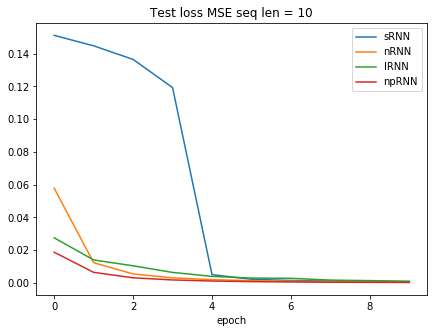

In [26]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 10")
plt.xlabel("epoch")
plt.plot(srnn10["test_err"], label="sRNN")
plt.plot(nrnn10["test_err"], label="nRNN")
plt.plot(irnn10["test_err"], label="IRNN")
plt.plot(nprnn10["test_err"], label="npRNN")
plt.legend()

### Sequence length is 50

In [11]:
net, inp, tar = create_network(50, 'srnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
srnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "srnn50", num_epochs=10)
np.save("srnn50-err", srnn50["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1660 	 train = 0.2008 	 norm = 0.3547 	 time = 65.54s
Epoch 1 test loss = 0.1651 	 train = 0.1677 	 norm = 0.4645 	 time = 65.84s
Epoch 2 test loss = 0.1648 	 train = 0.1670 	 norm = 0.3573 	 time = 67.39s
Epoch 3 test loss = 0.1644 	 train = 0.1666 	 norm = 0.2876 	 time = 65.95s
Epoch 4 test loss = 0.1640 	 train = 0.1663 	 norm = 0.2862 	 time = 65.74s
Epoch 5 test loss = 0.1637 	 train = 0.1660 	 norm = 0.1410 	 time = 66.68s
Epoch 6 test loss = 0.1635 	 train = 0.1658 	 norm = 0.7400 	 time = 66.55s
Epoch 7 test loss = 0.1632 	 train = 0.1655 	 norm = 0.1489 	 time = 66.58s
Epoch 8 test loss = 0.1630 	 train = 0.1652 	 norm = 0.1862 	 time = 65.44s
Epoch 9 test loss = 0.1628 	 train = 0.1650 	 norm = 0.3058 	 time = 61.53s


In [ ]:
net, inp, tar = create_network(50, 'irnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
irnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "add-data/irnn50", num_epochs=10)
np.save("irnn50-err", irnn50["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.0441 	 train = 0.1487 	 norm = 22.6715 	 time = 61.54s


In [14]:
net, inp, tar = create_network(50, 'nprnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nprnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "add-data/nprnn50", num_epochs=10)
np.save("add-data/nprnn50-err", nprnn50["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1633 	 train = 0.1734 	 norm = 2.4496 	 time = 61.16s
Epoch 1 test loss = 0.1595 	 train = 0.1638 	 norm = 2.9404 	 time = 61.04s
Epoch 2 test loss = 0.1936 	 train = 0.1598 	 norm = 6.3831 	 time = 61.04s
Epoch 3 test loss = 0.1121 	 train = 0.1437 	 norm = 22.6664 	 time = 61.20s
Epoch 4 test loss = 0.0451 	 train = 0.0692 	 norm = 25.6607 	 time = 62.26s
Epoch 5 test loss = 0.0180 	 train = 0.0381 	 norm = 7.8952 	 time = 61.81s
Epoch 6 test loss = 0.0111 	 train = 0.0256 	 norm = 1.3784 	 time = 61.77s
Epoch 7 test loss = 0.0430 	 train = 0.0180 	 norm = 10.4029 	 time = 61.78s
Epoch 8 test loss = 0.0114 	 train = 0.0144 	 norm = 5.7776 	 time = 61.77s
Epoch 9 test loss = 0.0054 	 train = 0.0119 	 norm = 0.4052 	 time = 61.78s


In [15]:
net, inp, tar = create_network(50, 'nrnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nrnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "add-data/nrnn50", num_epochs=10)
np.save("add-data/nrnn50-err", nrnn50["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1626 	 train = 0.1732 	 norm = 0.8093 	 time = 61.31s
Epoch 1 test loss = 0.1642 	 train = 0.1636 	 norm = 0.3212 	 time = 61.22s
Epoch 2 test loss = 0.1551 	 train = 0.1577 	 norm = 15.9034 	 time = 62.06s
Epoch 3 test loss = 0.0471 	 train = 0.1121 	 norm = 5.9784 	 time = 61.33s
Epoch 4 test loss = 0.0744 	 train = 0.0602 	 norm = 15.5705 	 time = 61.47s
Epoch 5 test loss = 0.0566 	 train = 0.0442 	 norm = 8.7112 	 time = 61.84s
Epoch 6 test loss = 0.0134 	 train = 0.0339 	 norm = 2.5434 	 time = 62.29s
Epoch 7 test loss = 0.0256 	 train = 0.0262 	 norm = 7.4569 	 time = 62.40s
Epoch 8 test loss = 0.0343 	 train = 0.0192 	 norm = 12.2994 	 time = 61.93s
Epoch 9 test loss = 0.0067 	 train = 0.0154 	 norm = 3.0685 	 time = 61.94s


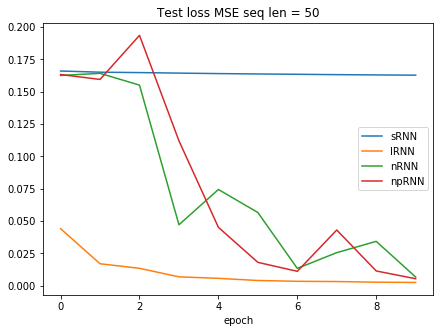

In [17]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 50")
plt.xlabel("epoch")
plt.plot(srnn50["test_err"], label="sRNN")
plt.plot(irnn50["test_err"], label="IRNN")
plt.plot(nrnn50["test_err"], label="nRNN")
plt.plot(nprnn50["test_err"], label="npRNN")
plt.legend()

### Sequence length is 70

In [ ]:
net, inp, tar = create_network(70, 'srnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
srnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "add-data/srnn70", num_epochs=10)
np.save("add-data/srnn70-err", srnn70["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1660 	 train = 0.1945 	 norm = 0.1958 	 time = 84.78s
Epoch 1 test loss = 0.1649 	 train = 0.1669 	 norm = 0.5113 	 time = 84.59s
Epoch 2 test loss = 0.1646 	 train = 0.1663 	 norm = 0.5218 	 time = 84.62s
Epoch 3 test loss = 0.1645 	 train = 0.1661 	 norm = 0.7331 	 time = 85.27s


In [ ]:
net, inp, tar = create_network(70, 'irnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
irnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "add-data/irnn70", num_epochs=10)
np.save("add-data/irnn70-err", irnn70["test_err"])

In [ ]:
net, inp, tar = create_network(70, 'nprnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nprnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "add-data/nprnn70", num_epochs=10)
np.save("add-data/nprnn70-err", nprnn70["test_err"])

In [ ]:
net, inp, tar = create_network(70, 'nrnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nrnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "add-data/nrnn70", num_epochs=10)
np.save("add-data/nrnn70-err", nrnn70["test_err"])

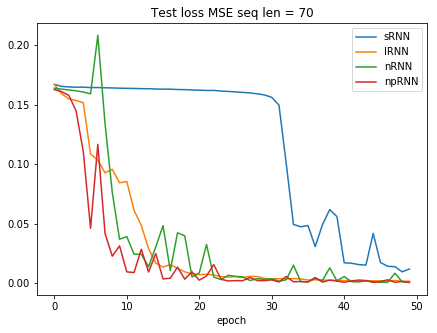

In [29]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 70")
plt.xlabel("epoch")
plt.plot(srnn70["test_err"], label="sRNN")
plt.plot(irnn70["test_err"], label="IRNN")
plt.plot(nrnn70["test_err"], label="nRNN")
plt.plot(nprnn70["test_err"], label="npRNN")
plt.legend()

### Sequence length is 100

In [ ]:
net, inp, tar = create_network(100, 'srnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
srnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "add-data/srnn100", num_epochs=10)
np.save("add-data/srnn100-err", srnn100["test_err"])

In [ ]:
net, inp, tar = create_network(100, 'irnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
irnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "add-data/irnn100", num_epochs=10)
np.save("add-data/irnn100-err", irnn100["test_err"])

In [ ]:
net, inp, tar = create_network(100, 'nprnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nprnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "add-data/nprnn100", num_epochs=10)
np.save("add-data/nprnn100-err", nprnn100["test_err"])

In [ ]:
net, inp, tar = create_network(100, 'nrnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nrnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "add-data/nrnn100", num_epochs=10)
np.save("add-data/nrnn100-err", nrnn100["test_err"])

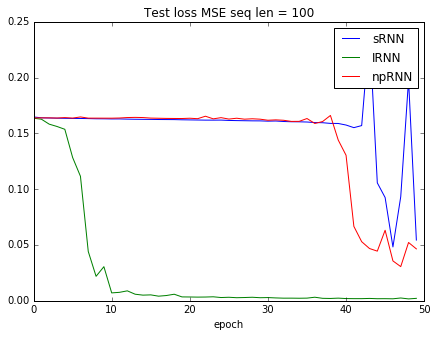

In [85]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 100")
plt.xlabel("epoch")
plt.plot(srnn100["test_err"], label="sRNN")
plt.plot(irnn100["test_err"], label="IRNN")
plt.plot(nprnn100["test_err"], label="npRNN")
plt.legend()

### Sequence length is 150

In [ ]:
net, inp, tar = create_network(150, 'srnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
srnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "add-data/srnn150", num_epochs=10)
np.save("add-data/srnn150-err", srnn150["test_err"])

In [ ]:
net, inp, tar = create_network(150, 'irnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
irnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "add-data/irnn150", num_epochs=10)
np.save("add-data/irnn150-err", irnn150["test_err"])

In [ ]:
net, inp, tar = create_network(150, 'nrnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nrnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "add-data/nrnn150", num_epochs=10)
np.save("add-data/nrnn150-err", nrnn150["test_err"])

In [ ]:
net, inp, tar = create_network(150, 'nprnn', 2, N_HIDDEN, 1, lasagne.nonlinearities.linear)
nprnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "add-data/nprnn150", num_epochs=10)
np.save("add-data/nprnn150-err", nprnn150["test_err"])

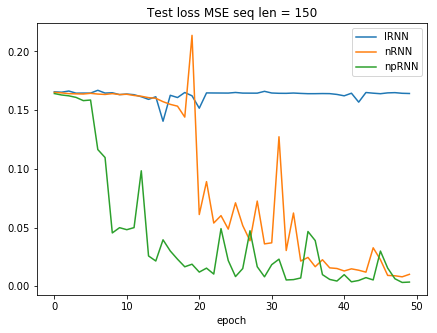

In [47]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 150")
plt.xlabel("epoch")
#plt.plot(srnn150["test_err"], label="sRNN")
plt.plot(irnn150["test_err"], label="IRNN")
plt.plot(nrnn150["test_err"], label="nRNN")
plt.plot(nprnn150["test_err"], label="npRNN")
plt.legend()

### Sequence length is 200

In [11]:
init_posdef_w(100)

NameError: name 'init_posdef_w' is not defined

In [14]:
net, inp, tar = create_network(200, NDIM, N_HIDDEN, 'nprnn')
lasagne.layers.get_all_param_values(net)[3]

Building network ...
The network has 10501 params


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [15]:
import sys
sys.version_info

sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)

In [47]:
net, inp, tar = create_network(200, NDIM, N_HIDDEN, 'srnn')
srnn200 = train(net, inp, tar, train_data[200]["x"], train_data[200]["y"],
                      test_data[200]["x"], test_data[200]["y"], "data/srnn200", num_epochs=50)
np.save("data/srnn200-err", srnn200["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25% Proc 50% Proc 75%
Epoch 0 test loss = 0.1716 	 train = 0.1914 	 norm = 0.2907 	 time = 239.90s	Proc 25% Proc 50% Proc 75%
Epoch 1 test loss = 0.1701 	 train = 0.1669 	 norm = 0.1872 	 time = 253.26s	Proc 25% Proc 50% Proc 75%
Epoch 2 test loss = 0.1698 	 train = 0.1663 	 norm = 0.8929 	 time = 252.80s	Proc 25% Proc 50% Proc 75%
Epoch 3 test loss = 0.1697 	 train = 0.1662 	 norm = 0.3048 	 time = 252.93s	Proc 25% Proc 50% Proc 75%
Epoch 4 test loss = 0.1697 	 train = 0.1661 	 norm = 0.2101 	 time = 252.10s	Proc 25% Proc 50% Proc 75%
Epoch 5 test loss = 0.1697 	 train = 0.1661 	 norm = 0.1482 	 time = 251.86s	Proc 25% Proc 50% Proc 75%
Epoch 6 test loss = 0.1696 	 train = 0.1661 	 norm = 0.3822 	 time = 251.89s	Proc 25% Proc 50% Proc 75%
Epoch 7 test loss = 0.1697 	 train = 0.1661 	 norm = 0.0904 	 time = 252.01s	Proc 25% Proc 50% Proc 75%
Epoch 8 test loss = 0.1696 	 train = 0.1661 	

In [ ]:
net, inp, tar = create_network(200, NDIM, N_HIDDEN, 'irnn')
irnn200 = train(net, inp, tar, train_data[200]["x"], train_data[200]["y"],
                      test_data[200]["x"], test_data[200]["y"], "data/irnn200", num_epochs=50)
np.save("data/irnn200-err", irnn200["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...


In [ ]:
net, inp, tar = create_network(200, NDIM, N_HIDDEN, 'nrnn')
nrnn200 = train(net, inp, tar, train_data[200]["x"], train_data[200]["y"],
                      test_data[200]["x"], test_data[200]["y"], "data/nrnn200", num_epochs=50)
np.save("data/nrnn200-err", nrnn200["test_err"])

In [ ]:
net, inp, tar = create_network(200, NDIM, N_HIDDEN, 'nprnn')
nprnn200 = train(net, inp, tar, train_data[200]["x"], train_data[200]["y"],
                      test_data[200]["x"], test_data[200]["y"], "data/nprnn200", num_epochs=50)
np.save("data/nprnn200-err", nprnn200["test_err"])

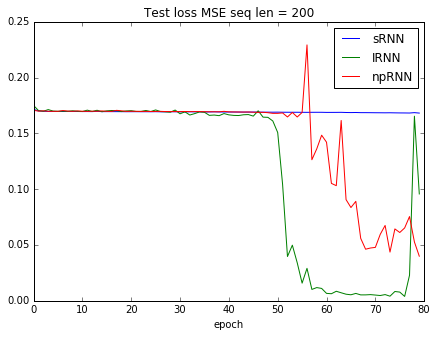

In [52]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 200")
plt.xlabel("epoch")
plt.plot(temp_srnn, label="sRNN")
plt.plot(irnn200["test_err"], label="IRNN")
plt.plot(nprnn200["test_err"], label="npRNN")
plt.legend()

## Sequence length is 300

In [ ]:
net, inp, tar = create_network(300, NDIM, N_HIDDEN, 'irnn')
irnn300 = train(net, inp, tar, train_data[300]["x"], train_data[300]["y"],
                      test_data[300]["x"], test_data[300]["y"], "data/irnn300", num_epochs=10)
np.save("data/irnn300-err", irnn300["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...


In [ ]:
net, inp, tar = create_network(300, NDIM, N_HIDDEN, 'nrnn')
nrnn300 = train(net, inp, tar, train_data[300]["x"], train_data[300]["y"],
                      test_data[300]["x"], test_data[300]["y"], "data/nrnn300", num_epochs=10)
np.save("data/nrnn300-err", nrnn300["test_err"])

In [ ]:
net, inp, tar = create_network(300, NDIM, N_HIDDEN, 'nprnn')
nprnn300 = train(net, inp, tar, train_data[300]["x"], train_data[300]["y"],
                      test_data[300]["x"], test_data[300]["y"], "data/nprnn300", num_epochs=10)
np.save("data/nprnn300-err", nprnn300["test_err"])

## Seq len 400

In [24]:
net, inp, tar = create_network(400, NDIM, N_HIDDEN, 'irnn')
irnn400 = train(net, inp, tar, train_data[400]["x"], train_data[400]["y"],
                      test_data[400]["x"], test_data[400]["y"], "data/irnn400", num_epochs=10)
np.save("data/irnn400-err", irnn400["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1692 	 train = 0.1924 	 norm = 2.5057 	 time = 496.64s
Epoch 1 test loss = 0.1719 	 train = 0.1673 	 norm = 0.1283 	 time = 498.29s
Epoch 2 test loss = 0.1686 	 train = 0.1671 	 norm = 2.2412 	 time = 497.53s
Epoch 3 test loss = 0.1695 	 train = 0.1670 	 norm = 3.1827 	 time = 496.47s
Epoch 4 test loss = 0.1682 	 train = 0.1667 	 norm = 0.6971 	 time = 497.22s
Epoch 5 test loss = 0.1678 	 train = 0.1667 	 norm = 1.0240 	 time = 499.63s
Epoch 6 test loss = 0.1677 	 train = 0.1666 	 norm = 1.9427 	 time = 497.92s
Epoch 7 test loss = 0.1689 	 train = 0.1666 	 norm = 0.0902 	 time = 497.48s
Epoch 8 test loss = 0.1677 	 train = 0.1665 	 norm = 0.5591 	 time = 500.98s
Epoch 9 test loss = 0.1678 	 train = 0.1665 	 norm = 1.8536 	 time = 497.05s


In [ ]:
net, inp, tar = create_network(400, NDIM, N_HIDDEN, 'nrnn')
nrnn400 = train(net, inp, tar, train_data[400]["x"], train_data[400]["y"],
                      test_data[400]["x"], test_data[400]["y"], "data/nrnn400", num_epochs=10)
np.save("data/nrnn400-err", nrnn400["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Epoch 0 test loss = 0.1678 	 train = 0.1769 	 norm = 0.5829 	 time = 506.20s
Epoch 1 test loss = 0.1674 	 train = 0.1666 	 norm = 2.4825 	 time = 509.79s
Epoch 2 test loss = 0.1686 	 train = 0.1663 	 norm = 1.1828 	 time = 502.77s
Epoch 3 test loss = 0.1683 	 train = 0.1663 	 norm = 0.2922 	 time = 505.48s
Epoch 4 test loss = 0.1674 	 train = 0.1663 	 norm = 0.3555 	 time = 502.42s
Epoch 5 test loss = 0.1675 	 train = 0.1662 	 norm = 0.5281 	 time = 504.33s
Epoch 6 test loss = 0.1675 	 train = 0.1662 	 norm = 1.1894 	 time = 504.73s
Epoch 7 test loss = 0.1678 	 train = 0.1661 	 norm = 2.0760 	 time = 505.61s
Epoch 8 test loss = 0.1673 	 train = 0.1661 	 norm = 0.1917 	 time = 503.57s
Epoch 9 test loss = 0.1683 	 train = 0.1661 	 norm = 0.5542 	 time = 504.69s


In [ ]:
net, inp, tar = create_network(400, NDIM, N_HIDDEN, 'nprnn')
nprnn400 = train(net, inp, tar, train_data[400]["x"], train_data[400]["y"],
                      test_data[400]["x"], test_data[400]["y"], "data/nprnn400", num_epochs=10)
np.save("data/nprnn400-err", nprnn300["test_err"])

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...


In [141]:
def train_adam(network, inp, target_values, Xtrain, ytrain, Xtest, ytest, filename, num_epochs=NUM_EPOCHS):
    train_err = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)

    # Cost is MSE
    cost = T.mean((network_output - target_values)**2)
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cost, all_params)
    scaled_grads = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP)
    updates = lasagne.updates.adam(scaled_grads, all_params, LEARNING_RATE)
    
    print("Compiling functions ...")
    train_fn = theano.function([inp, target_values], cost, updates=updates, allow_input_downcast=True)
    compute_cost = theano.function([inp, target_values], cost, allow_input_downcast=True)
    
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_idxs = np.arange(TRAIN_SIZE)
    for epoch in range(num_epochs):
        start_time = time.time()
        np.random.shuffle(train_idxs)
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]
            train_err[epoch] += train_fn(Xtrain[idx, :, :], ytrain[idx, np.newaxis])
            
            if batch == num_batches // 4:
                print("Proc 25%", end="\t")
            if batch == num_batches // 2:
                print("Proc 50%", end="\t")
            if batch == num_batches // 4 * 3:
                print("Proc 75%")
                
        train_err[epoch] /= num_batches
        test_err[epoch] = compute_cost(Xtest, ytest[:, np.newaxis])
        print("Epoch {} test loss = {:.4f} \t train = {:.4f} \t time = {:.2f}s".format(
                epoch, test_err[epoch], train_err[epoch], time.time() - start_time), end="\t")
    np.save(file=filename, arr=lasagne.layers.get_all_param_values(network))
    return pack(network, inp, target_values, train_err, test_err, train_fn, compute_cost)